In [1]:
%pip install -U langgraph langchain_openai langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.7 MB/s eta 0:00:00


In [2]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


### First, let's go set up LangSmith!

https://langsmith.com

In [3]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "LangsmithAPI" # Replace with your LangChain API Key

### Next, here is a useful function in LangChain community:

In [4]:
from google.colab import userdata
serper = userdata.get("Serper")

In [5]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper(serper_api_key = serper)
serper.run("What is current situation between iran and israel?")

'Israel says its assault on Iran is necessary to prevent the country from building a nuclear weapon – which Israel sees as an existential threat ... Iran and Israel\'s exchange of aerial attacks have forced multiple countries in the region to temporarily close their airspaces in recent days, ... Iranian Supreme Leader Ayatollah Ali Khamenei said Iran "will never compromise with Zionists", in a series of posts on X. "We will show the ... The escalation between Israel and Iran has raised many important questions about a region already facing crises on multiple fronts. Iran launched new missile barrages against Israel, but none appeared to do significant damage. It comes as Israel destroyed fighter jets, ... US President Donald Trump has stepped up his rhetoric against Iran\'s supreme leader and raised questions about the extent of US involvement ... Iran has warned that any United States intervention in the conflict with Israel would risk an “all-out war” as the two sides traded attacks 

### Now here is a LangChain wrapper class for converting functions into Tools

In [6]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run, # a regular Python function (serper.run) turning into a tool, the agent can call dynamically, based on your query and the tool's description.
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [7]:
tool_search.invoke("What is the gold rate today in karachi?")

'Gold Karachi · Rs. 360100.00. 24K - 1 Tola Gold Rate in Karachi · Rs. 308733. 24K (10 Gram) Gold Price in Karachi · Rs. 30873.3. 24K Karachi Gold Rate 1 Gram ... Today GOLD Price is Rs 360,000. 24k GOLD rate in Pakistan is Rs 360,000. Sarmaaya.pk provides Gold live price updates, Gold conversion calculator and much more. The gold rate in Pakistan today is PKR 360,600 tola for 24 karat gold, and 22 karat gold price is PKR 330,635 1 tola on Wednesday, Jun 18, 2025. The current ... The current gold rate today Karachi is PKR 330,635 per tola for 22 carat. The highest quality gold available is 24K, but gold can also be found in other ... Gold Rates · Per Tola · Rs. 363,700/- · 24K Gold · Per 10 Gram · Rs. 311,800/- · 24K Gold · Per Gram · Rs. 31,180/- ... Gold price in Pakistan today for 24 Karat gold is Rs. 360,000 per tola and Rs. 308,650 per 10 grams. Furthermore, the gold price in Pakistan today for 22 Carat ... 365400 as per Karachi Gold Market and per gram gold rate in Karachi is Rs.

### And now let's write a tool ourselves

We'll pick a familiar one

In [8]:
import http.client

conn = http.client.HTTPSConnection("open-weather13.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "f39e410c6bmshad955ee7a034f9dp103e71jsn04ceecae5446",
    'x-rapidapi-host': "open-weather13.p.rapidapi.com"
}

conn.request("GET", "/fivedaysforcast?latitude=40.730610&longitude=-73.935242&lang=EN", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"cod":"200","message":0,"cnt":40,"list":[{"dt":1750248000,"main":{"temp":292.07,"feels_like":292.55,"temp_min":292.07,"temp_max":293.22,"pressure":1014,"sea_level":1014,"grnd_level":1013,"humidity":97,"temp_kf":-1.15},"weather":[{"id":804,"main":"Clouds","description":"overcast clouds","icon":"04d"}],"clouds":{"all":100},"wind":{"speed":3.1,"deg":195,"gust":5.37},"visibility":10000,"pop":0.67,"sys":{"pod":"d"},"dt_txt":"2025-06-18 12:00:00"},{"dt":1750258800,"main":{"temp":293.87,"feels_like":294.35,"temp_min":293.87,"temp_max":297.48,"pressure":1014,"sea_level":1014,"grnd_level":1012,"humidity":90,"temp_kf":-3.61},"weather":[{"id":804,"main":"Clouds","description":"overcast clouds","icon":"04d"}],"clouds":{"all":96},"wind":{"speed":2.44,"deg":222,"gust":4.52},"visibility":10000,"pop":0,"sys":{"pod":"d"},"dt_txt":"2025-06-18 15:00:00"},{"dt":1750269600,"main":{"temp":297.24,"feels_like":297.77,"temp_min":297.24,"temp_max":299.82,"pressure":1013,"sea_level":1013,"grnd_level":1011,"humi

In [9]:
def get_weather(city: str):
    """Fetches weather information for a given city using RapidAPI."""
    url = "https://open-weather13.p.rapidapi.com/city"
    querystring = {"city": city, "lang": "EN"}
    headers = {
        "x-rapidapi-key": "f39e410c6bmshad955ee7a034f9dp103e71jsn04ceecae5446", # Using userdata to store the key
        "x-rapidapi-host": "open-weather13.p.rapidapi.com"
    }
    try:
        response = requests.get(url, headers=headers, params=querystring)
        response.raise_for_status()  # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        return f"Error fetching weather data: {e}"

In [10]:
from langchain.agents import Tool

tool_weather = Tool(
    name="get_weather",
    func=get_weather,
    description="Useful for when you need to get the current weather for a city. Input should be a city name."
)
tool_weather.invoke("Lahore")

{'coord': {'lon': 74.3436, 'lat': 31.5497},
 'weather': [{'id': 802,
   'main': 'Clouds',
   'description': 'scattered clouds',
   'icon': '03d'}],
 'base': 'stations',
 'main': {'temp': 102.18,
  'feels_like': 113.43,
  'temp_min': 102.18,
  'temp_max': 102.18,
  'pressure': 993,
  'humidity': 39,
  'sea_level': 993,
  'grnd_level': 970},
 'visibility': 6000,
 'wind': {'speed': 6.91, 'deg': 180},
 'clouds': {'all': 40},
 'dt': 1750246494,
 'sys': {'type': 1,
  'id': 7585,
  'country': 'PK',
  'sunrise': 1750204661,
  'sunset': 1750255789},
 'timezone': 18000,
 'id': 1172451,
 'name': 'Lahore',
 'cod': 200}

### When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [11]:
tools = [tool_search, tool_weather]

In [12]:
# Step 1: Define the State object
class State(TypedDict): #This line defines a class named State that inherits from TypedDict. This is overall a data structure.
# State is a class that tells Python: “I expect a dictionary with a key called messages, and it must be a list with special behavior.”
# You create an object when you use this class to hold actual data.
    messages: Annotated[list, add_messages]

In [13]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [14]:
from google.colab import userdata
openkey = userdata.get('OpenAI')

In [15]:
# This is different:

llm = ChatOpenAI(model="gpt-4.1-nano", api_key = openkey)
llm_with_tools = llm.bind_tools(tools)

## You’re building a LangGraph with two nodes:

1. A chatbot node that uses an LLM to generate responses.
2. A tools node that gives the agent access to external tools (like search, weather, etc.).


In [16]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))



In [17]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")

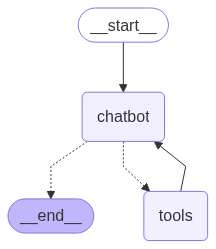

In [18]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### 🧠 First, think of LangGraph as a flowchart:
- You define nodes like chatbot and tools.
- Then you define how data flows between them using edges.

These edges can be:
- Simple: always go from Node A to Node B.
- Conditional: go to different nodes based on logic.

🧩 Let's break it down step by step:
```python
### graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")


✅ **Purpose**: Adds a **conditional edge** from `"chatbot"` to `"tools"`.

- This means:  
  → After the chatbot runs, check `tools_condition`.  
  → If it returns `True` (i.e., a tool is needed), go to the `"tools"` node.

🧠 `tools_condition` is a function you must define somewhere, and it checks:
> *"Did the LLM request a tool?"*

---

#### ```python
graph_builder.add_edge(START, "chatbot")


✅ Purpose: Set the starting point of the graph.

- The graph begins with the chatbot node.
- The user message first goes to the LLM.



In [19]:
#graph_builder.add_edge("tools", "chatbot")


✅ **Purpose**: Create a loop between tools and chatbot.

- Once the tool (like search, weather, etc.) is used,
- The flow **goes back to the chatbot** to let the LLM decide what to say next.

---

### 🔁 Visual Summary:

```text
START → chatbot ──────▶ tools
           ▲               │
           └──── back ◀────┘



### ✅ TL;DR:
You're wiring up the flow:

1. Start at chatbot
2. If a tool is needed → go to tools
3. After using the tool → go back to chatbot to continue the conversation.


### 🔚 Why there's no END edge here (yet):
In LangGraph, the END edge only needs to be added if you want to stop the flow explicitly.

But in your case:



In [20]:
#graph_builder.add_edge(START, "chatbot")
#graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
#graph_builder.add_edge("tools", "chatbot")

You’ve built a looping system where:

1. The flow starts at "chatbot".
2. If a tool is needed → go to "tools" → then back to "chatbot".
🔁 It keeps repeating until you decide to stop it manually.

🧠 So when do you need to add END?
You’d use:


In [21]:
#graph_builder.add_edge("chatbot", END)

### When you want to say:

"If the chatbot is done — like it answered the user and doesn’t need tools — then finish here."

Usually, this is added conditionally like:

In [22]:
#graph_builder.add_conditional_edges("chatbot", tools_condition, "tools", default=END)

Otherwise → go to END

### ✅ TL;DR:
You haven’t added END yet because your flow is looping indefinitely — it keeps going from chatbot → tools → chatbot.
You should add an END edge if you want to exit the loop when the chatbot is done responding.

### That's it! And, let's do this:

In [23]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://18fe5788c66b0010db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://18fe5788c66b0010db.gradio.live


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

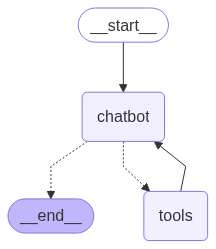

In [25]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4.1-nano", api_key = openkey)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8399d7afb0fe75c37f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [27]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [28]:
# Most recent first

list(graph.get_state_history(config))

[]

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [29]:
!pip install langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 5.0 MB/s eta 0:00:00


In [30]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

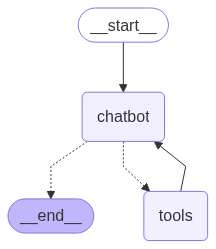

In [31]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4.1-nano", api_key = openkey)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://21232f189a7d894be8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
